# 0. 프로젝트 환경구축 하기

## Colab과 Github 활용하기

### Colab에 drive 마운트 하기
- 자신의 구글 계정 drive에 접근합니다. 
- 구글에서 인증요청이 오면 동의하고 진행합니다.
- 순서대로 진행하게 되면 좌측 카테고리에 drive 폴더가 생성됩니다. 
- 생성되지 않았다면 새로고침 버튼을 통해 drive 폴더가 표시되게 합니다. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

- 드라이브의 MyDrive 폴더로 현재 위치를 변경합니다.
- 이곳에 우리가 작업할 프로젝트를 불러올 것입니다. 

In [ ]:
cd "/content/drive/MyDrive"

### Github에서 프로젝트 불러오기

- Github를 통해서 실습 프로젝트를 불러옵니다. 

In [ ]:
!git clone https://github.com/CTGAN-syntheticdata-generation/Selection-of-criminals_with_syndata.git

- 실습데이터가 있는 폴더로 현재 위치를 변경합니다. 

In [ ]:
cd "/content/drive/MyDrive/Selection-of-criminals_with_syndata/CTGAN_syndata_generaton" 

# 1. Generate synthetic data with CTGAN

## CTGAN에 대한 소개

- CTGAN은 Conditional Tabular GAN의 약자이며 테이블 형식 데이터를 생성하기 위해 특별히 설계된 GAN 아키텍처 유형입니다. 
- CTGAN은 원본 데이터의 통계적 특성을 유지하면서 실제 데이터와 유사한 표 형식 데이터를 생성할 수 있습니다.
- CTGAN은 실제 데이터와 합성 데이터를 구분하는 판별자와 실제 데이터 분포와 일치하는 합성 데이터를 생성하는 생성기를 사용하여 실제 데이터와 합성 데이터 모두에 대해 모델을 교육하여 작동합니다. 
- 생성기는 실제 데이터와 유사하고 사실적인 합성 데이터를 생성하도록 훈련되는 반면 판별자는 실제 데이터와 합성 데이터를 구별하도록 훈련됩니다.

## Load Library

- CTGAN 라이브러리 설치하기
- 최초 실행시 사용자 환경에 따라 오류가 발생할 수 있으나 다시 실행하면 일부 문제 해결 가능

In [ ]:
!pip install ctgan

- Library for data type
- 데이터 프레임을 사용하기 위해 판다스 라이브러리를 활용합니다. 

In [1]:
import pandas as pd

- Library for model trainning 
- Use torch to facilitate computation using GPU

In [2]:
import torch
#Tools for Python Memory Management
import gc 
from ctgan import CTGAN

C:\Users\0614_\anaconda3\envs\wco_ctgan\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Check we can use GPU(with cuda)

In [3]:
torch.cuda.is_available()

True

In [4]:
# Manually turn off objects that are not currently needed
gc.collect()
# Function to clear the CUDA memory cache curently in use
torch.cuda.empty_cache()

- Library for graphing
- seaborn과 matplotlib를 통해서 데이터를 시각화 합니다. 

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

- setting etc 
- copy는 데이터를 복사하는 라이브러리
- time은 시스템의 시간을 확인할 수 있는 라이브러리

In [6]:
import copy
import time

import warnings
warnings.filterwarnings("ignore")

- setting Jupyter Notebook

In [7]:
#Jupiter Cell Full Screen View
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# useful for debuging (print the results of both formulas and functions entered in one cell of Jupiter)
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
# Each column width at maximum (print all column contents)
pd.set_option('display.max_colwidth', -1)
# Show up to 500 rows
pd.set_option('display.max_rows', 500)
# Display up to 500 columns
pd.set_option('display.max_columns', 500)
# Total length of data frame
pd.set_option('display.width', 1000)

print('ready to run')
# logging starttime 
startTime = time.time()

ready to run


## Load Data

- 미리 준비해둔 가상의 관세청 데이터를 불러옵니다.

In [8]:
df_raw=pd.read_csv('df_syn_en.csv', encoding='utf-8-sig')

## Data copy

- 불러온 데이터를 안전하게 사용하기 위해 복사합니다.

In [9]:
df_raw_copy = copy.deepcopy(df_raw)

## Check the data
- 'dec_num' deduplication (unique value)
- Sorting by 'dec_date' (ASC)
- Check for outliers ('imp_dec_code')

In [10]:
#Change of 'dec_date' type
df_raw_copy['dec_date'] = pd.to_datetime(df_raw_copy['dec_date']) 
#'dec_num' deduplication
df_org = df_raw_copy.drop_duplicates(['dec_num'], keep = 'first') 
#'dec_date' sorting ASC
df_org = df_org.sort_values(by = ['dec_date'], axis = 0) 

In [11]:
#불러온 데이터의 형태를 확인
df_org.shape

(54000, 22)

In [12]:
#불러온 데이터의 예시를 확인
df_org.head()

,dec_num,dec_date,dec_custom_code,imp_dec_code,imp_trd_code,imp_typ_code,collect_code,typ_transport_code,dec_mark,importer,ovs_cust_code,exps_carr_code,HS10,country_ship_code,country_orig_code,trff_rate,trff_class_code,country_orig_mark_code,dec_weight,taxabal_price_KRW,crime_yn,key_exposure
0,97061800,2020-01-01,30,B,11,21,11,10,ZZR1LT6,QLRUBN9,0VKY2BR,NaN,4408909195,BE,BE,0.0,FEU1,G,108.0,372254.40,0,0
25,21073696,2020-01-01,70,B,11,21,11,10,0M7YBNH,55BH1VM,OOZO637,NaN,9206009000,NP,NP,0.0,R,S,60.0,3486.00,0,0
23,64705381,2020-01-01,30,B,11,21,11,10,CSYO98C,Y3QS787,KQ8UJP7,NaN,7326909000,DE,DE,0.0,FEU1,Y,22.0,33.00,0,0
22,25886903,2020-01-01,20,B,11,21,11,10,5K1441H,EHXQG9A,W3K0JC6,NaN,8517623900,CA,CA,0.0,CIT,Y,14.1,13320.27,0,0
21,19201172,2020-01-01,40,B,11,21,11,10,A7POIBB,Q8MAKJD,KILND1W,NaN,2005999000,CN,CN,18.0,FCN1,G,48320.0,4575904.00,0,0


- 불러온 데이터의 기본 정보를 확인 합니다.
- 일부 데이터가 적은 것을 확인할 수 있습니다.

In [13]:
#dec_date의 타입이 유일하게 다른 datetime64[ns]임을 확인
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54000 entries, 0 to 53999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   dec_num                 54000 non-null  int64         
 1   dec_date                54000 non-null  datetime64[ns]
 2   dec_custom_code         54000 non-null  int64         
 3   imp_dec_code            54000 non-null  object        
 4   imp_trd_code            54000 non-null  int64         
 5   imp_typ_code            54000 non-null  int64         
 6   collect_code            54000 non-null  int64         
 7   typ_transport_code      54000 non-null  int64         
 8   dec_mark                54000 non-null  object        
 9   importer                54000 non-null  object        
 10  ovs_cust_code           48799 non-null  object        
 11  exps_carr_code          9538 non-null   object        
 12  HS10                    54000 non-null  int64 

- describe을 활용해 모든 칼럼에 대한 데이터 요약을 확인합니다.
- 수치형 데이터의 mean, std 등 통계정보를 요약합니다.

In [14]:
# 범주형 데이터의 가장 빈번하게 등장하는 변수 빈번하게 등장한 횟수 등의 정보를 요약해줌
df_org.describe(include = 'all')

,dec_num,dec_date,dec_custom_code,imp_dec_code,imp_trd_code,imp_typ_code,collect_code,typ_transport_code,dec_mark,importer,ovs_cust_code,exps_carr_code,HS10,country_ship_code,country_orig_code,trff_rate,trff_class_code,country_orig_mark_code,dec_weight,taxabal_price_KRW,crime_yn,key_exposure
count,5.400000e+04,54000,54000.000000,54000,54000.000000,54000.000000,54000.000000,54000.000000,54000,54000,48799,9538,5.400000e+04,54000,54000,54000.000000,54000,54000,5.400000e+04,5.400000e+04,54000.000000,54000.000000
unique,NaN,547,NaN,3,NaN,NaN,NaN,NaN,1238,14482,12201,81,NaN,102,119,NaN,49,6,NaN,NaN,NaN,NaN
top,NaN,2021-02-01 00:00:00,NaN,B,NaN,NaN,NaN,NaN,DWNJQL8,708A72F,7PN0VA5,MWIDNS,NaN,CN,CN,NaN,A,E,NaN,NaN,NaN,NaN
freq,NaN,505,NaN,53992,NaN,NaN,NaN,NaN,1777,196,271,3109,NaN,24956,27486,NaN,20367,15269,NaN,NaN,NaN,NaN
first,NaN,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2021-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.507171e+07,NaN,31.227241,NaN,19.554000,20.666093,17.532352,23.166111,NaN,NaN,NaN,NaN,6.172031e+09,NaN,NaN,7.430657,NaN,NaN,2.674132e+04,3.512241e+06,0.215796,0.225889
std,2.596503e+07,NaN,16.053572,NaN,24.107826,2.393293,12.319247,15.378693,NaN,NaN,NaN,NaN,2.615394e+09,NaN,NaN,26.708652,NaN,NaN,6.659435e+05,5.405280e+07,0.411377,0.441647
min,1.000019e+07,NaN,10.000000,NaN,11.000000,11.000000,0.000000,10.000000,NaN,NaN,NaN,NaN,1.012910e+08,NaN,NaN,0.000000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,3.256710e+07,NaN,20.000000,NaN,11.000000,21.000000,11.000000,10.000000,NaN,NaN,NaN,NaN,3.926909e+09,NaN,NaN,0.000000,NaN,NaN,9.400000e+00,5.071350e+02,0.000000,0.000000


### Outlier Found
- Ensure that a particular value is concentrated in one column
- Recognizes that only one value can be biased and extracted during sampling

In [15]:
df_org['imp_dec_code'].value_counts()

B    53992
D    7    
A    1    
Name: imp_dec_code, dtype: int64

### Check the correlation
- 상관도 분석은 두 변수간의 선형적인 상관관계를 분석하는 방법입니다. 
- 두 변수간에 어떤 종류의 연관성이 있는 지 파악하는데 활용합니다. 
- Heatmap을 통해서 각 'imp_dec_code' 칼럼이 다른 칼럼에 어떤 영향을 미치는 지 시각적으로 확인하고자 합니다. 

#### Working with encoding data frames as numeric data

- sklearn에서 데이터 전처리를 위해 사용하는 라이브러리 LableEncoder를 활용
- LabelEncoder는 범주형 데이터에 라벨링을 통해서 수치형 변수로 변환합니다.

In [16]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

#복사한 데이터를 순서대로 가져와 encoding 후에 데이터를 입력합니다. 
for column_name,item in df_raw_copy.iteritems(): 
    encoder.fit(item)
    labels = encoder.transform(item)
    df_raw_copy[column_name] = labels

#### Making Heatmap

In [17]:
#matplotlib의 font_manager 객체를 통해 우리가 그릴 Heatmap의 폰트를 설정합니다.
import matplotlib.font_manager as fm

#구글 코랩에 기본으로 제공되는 DejaVu Sans라는 글꼴을 활용합니다. 
plt.rcParams['font.family'] = 'DejaVu Sans'

#font 설정을 위한 함수, 폰트가 설치되어있는 경로와 사이즈를 결정한다. 
def set_font():
    font_path = '/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/'
    fontprop = fm.FontProperties(fname=font_path, size=12)
    return fontprop

fontprop = set_font()

In [18]:
#데이터프레임의 상관도를 구합니다. 
corr = df_raw_copy.corr()

- Heatmap을 확인해 보니 imp_dec_code와 높은 상관도를 가지는 칼럼은 존재하지 않습니다. 
- 특별한 조치를 취하지 않고 그대로 작업을 진행하겠습니다. 

<AxesSubplot: >

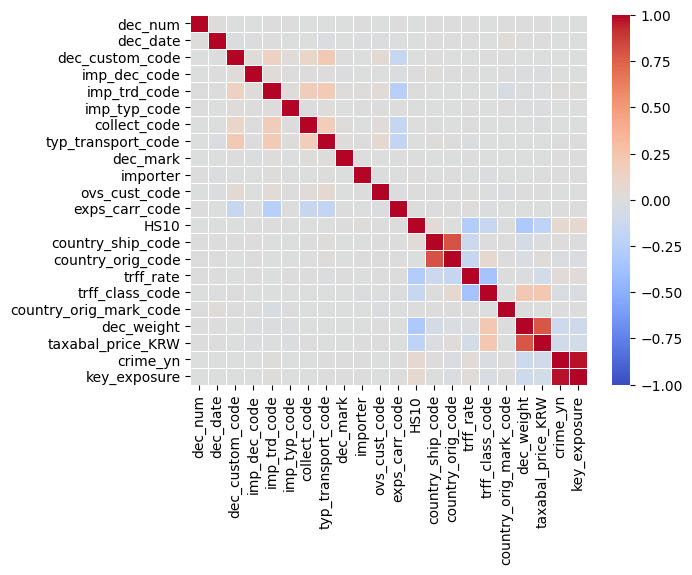

In [19]:
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths =0.5, annot_kws={'size':10, 'fontproperties':fontprop},vmin=-1.0)

## Random data sampling 
- 기본 데이터에서 훈련시킬 데이터를 추출합니다. 
- 이번 실습에서 데이터의 양은 1600개 정도가 적당합니다. 샘플 양이 많아지면 작업시간이 크게 증가합니다.

In [20]:
df_sample=df_org.sample(1600,replace=False)

## 샘플 데이터 처리

- Preserve correlation by grouping well-correlated columns into a single multiple column
- Correlation may not be preserved during data generation

In [21]:
cols = ['HS10', 'country_ship_code', 'country_orig_code', 'trff_rate', 'trff_class_code', 'dec_weight','taxabal_price_KRW','crime_yn', 'key_exposure']
df_sample['HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key'] = df_sample[cols].apply(lambda row: '^'.join(row.values.astype(str)), axis=1)

### 불필요한 칼럼 삭제
- Delete Duplicate Columns
- 'dec_date'의 데이터 타입은 일부 colab 환경에서 오류가 발생하여 삭제하고 진행하겠습니다. (우범화물과 관련성이 적어 학습에는 큰 지장을 주지 않습니다.)
- 'dec_num'은 우범화물과 관련이 없기 때문에 삭제합니다. 

In [22]:
df_sample=df_sample.drop(cols, axis=1)
df_sample=df_sample.drop('dec_date', axis=1)
df_sample=df_sample.drop('dec_num', axis=1)

## Trainning model with CTGAN 

- CTGAN 알고리즘을 활용하여 모델 학습을 실시합니다. 

In [23]:
# 학습할 카테고리의 리스트를 변수로 선언합니다. 
categorical_columns =[ 'dec_custom_code','imp_dec_code','imp_trd_code',\
                      'imp_typ_code','collect_code', 'typ_transport_code','dec_mark','importer',\
                      'ovs_cust_code','exps_carr_code','country_orig_mark_code','HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key']

In [24]:
#CTGAN 모델을 학습합니다. 
ctgan = CTGAN(verbose=True)
startTime = time.time()
ctgan.fit(df_sample, categorical_columns, epochs = 500)
endTime = time.time()

print('time:', endTime - startTime )

Epoch 1, Loss G:  3.8310,Loss D: -0.0520
Epoch 2, Loss G:  4.0989,Loss D: -0.1743
Epoch 3, Loss G:  3.8946,Loss D: -0.2838
Epoch 4, Loss G:  3.8887,Loss D: -0.3796
Epoch 5, Loss G:  4.0918,Loss D: -0.5185
Epoch 6, Loss G:  4.2221,Loss D: -0.6170
Epoch 7, Loss G:  4.1497,Loss D: -0.7361
Epoch 8, Loss G:  3.9492,Loss D: -0.8472
Epoch 9, Loss G:  3.7739,Loss D: -0.9153
Epoch 10, Loss G:  3.9598,Loss D: -1.0082
Epoch 11, Loss G:  3.8923,Loss D: -1.0743
Epoch 12, Loss G:  3.8698,Loss D: -1.0941
Epoch 13, Loss G:  3.8037,Loss D: -1.0067
Epoch 14, Loss G:  3.7235,Loss D: -0.9786
Epoch 15, Loss G:  3.4319,Loss D: -0.6864
Epoch 16, Loss G:  3.5355,Loss D: -0.6627
Epoch 17, Loss G:  3.2464,Loss D: -0.5205
Epoch 18, Loss G:  3.3128,Loss D: -0.3927
Epoch 19, Loss G:  2.9462,Loss D: -0.2827
Epoch 20, Loss G:  3.2278,Loss D: -0.1698
Epoch 21, Loss G:  3.1603,Loss D: -0.2608
Epoch 22, Loss G:  2.9976,Loss D: -0.0029
Epoch 23, Loss G:  2.9420,Loss D:  0.0226
Epoch 24, Loss G:  3.0395,Loss D:  0.0295
E

## Generating synthetic data with trained model

- 샘플링 한 데이터 갯수 만큼 데이터를 생성합니다.
- 더 많은 데이터를 생성할 경우 상관도를 비롯해 두 테이블간 통계적 유사함을 점차 잃게 됩니다.

In [25]:
#샘플링 한 데이터 갯수 만큼 데이터를 생성함
df_syn = ctgan.sample(len(df_sample))

## Save the new data

In [26]:
# 합성된 데이터의 정보를 확인 합니다. 
df_syn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 12 columns):
 #   Column                                                Non-Null Count  Dtype 
---  ------                                                --------------  ----- 
 0   dec_custom_code                                       1600 non-null   int64 
 1   imp_dec_code                                          1600 non-null   object
 2   imp_trd_code                                          1600 non-null   int64 
 3   imp_typ_code                                          1600 non-null   int64 
 4   collect_code                                          1600 non-null   int64 
 5   typ_transport_code                                    1600 non-null   int64 
 6   dec_mark                                              1600 non-null   object
 7   importer                                              1600 non-null   object
 8   ovs_cust_code                                         1395 non-null 

In [27]:
#여러 칼럼을 합쳐두었던 데이터를 분리하여 각 칼럼을 생성합니다. 
df_syn['HS10']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[0]
df_syn['country_ship_code']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[1]
df_syn['country_orig_code']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[2]
df_syn['trff_rate']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[3]
df_syn['trff_class_code']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[4]
df_syn['dec_weight']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[5]
df_syn['taxabal_price_KRW']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[6]
df_syn['crime_yn']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[7]
df_syn['key_exposure']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[8]

In [28]:
#여러 칼럼이 합쳐진 칼럼을 삭제 합니다.
df_syn = df_syn.drop(['HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key'],axis=1)

- Sort columns the same as the original data
- 여러 칼럼을 합친 뒤 분리가 되었기 때문에 칼럼의 순서가 뒤섞였습니다. 
- 원본 데이터와 원활한 비교를 위해 칼럼 순서대로 정렬합니다.

In [29]:
#칼럼을 순서대로 추출하여 임시데이터프레임에 담는다.
df_tmp = df_syn[['HS10','country_ship_code','country_orig_code','trff_rate',\
                 'trff_class_code','country_orig_mark_code','dec_weight','taxabal_price_KRW','crime_yn','key_exposure']]
#추출된 칼럼을 합성데이터가 담긴 데이터프레임에서 삭제한다. 
df_syn = df_syn.drop(['HS10','country_ship_code','country_orig_code','trff_rate',\
                 'trff_class_code','country_orig_mark_code','dec_weight','taxabal_price_KRW','crime_yn','key_exposure'],axis=1)
#concat 함수를 통해 임시 데이터프레임을 기존 데이터프레임 뒤에 붙인다. 
df_syn = pd.concat([df_syn, df_tmp], axis = 1)

In [30]:
# 합성데이터의 정보를 점검합니다.
df_syn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   dec_custom_code         1600 non-null   int64 
 1   imp_dec_code            1600 non-null   object
 2   imp_trd_code            1600 non-null   int64 
 3   imp_typ_code            1600 non-null   int64 
 4   collect_code            1600 non-null   int64 
 5   typ_transport_code      1600 non-null   int64 
 6   dec_mark                1600 non-null   object
 7   importer                1600 non-null   object
 8   ovs_cust_code           1395 non-null   object
 9   exps_carr_code          438 non-null    object
 10  HS10                    1600 non-null   object
 11  country_ship_code       1600 non-null   object
 12  country_orig_code       1600 non-null   object
 13  trff_rate               1600 non-null   object
 14  trff_class_code         1600 non-null   object
 15  coun

In [31]:
#데이터를 지정된 경로에 저장합니다. 
df_syn.to_csv('./data_sample/df_syn_en_14.csv', index=False, encoding='utf-8-sig')